In [1]:
import networkx as nx 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import optimize
import scipy
import sys
import pandas as pd

from src import SimGame as sg
from src import helperfunctions as hf

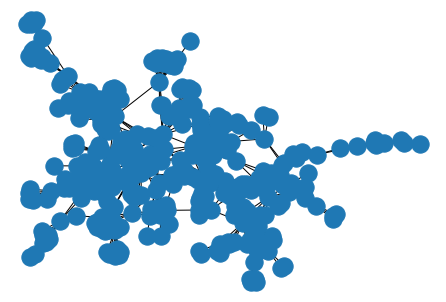

In [2]:
path = 'C:/Users/zuzan/OneDrive/Dokumenty/Master-Papers/real_networks/ca-netscience.txt'


df = pd.read_csv(path, delimiter = " ")

def extract_network(df):

    G = nx.from_pandas_edgelist(df,source='FromNodeId', target='ToNodeId')
    subgraphs=[G.subgraph(c) for c in nx.connected_components(G)]
    subgraphs_sizes = sorted([len(subgraph.nodes) for subgraph in subgraphs])
    
    mapping = {i:k for k,i in enumerate(list(G.nodes))}
    H=nx.relabel_nodes(G,mapping)
    
    return H


G = extract_network(df)

nx.draw(G)



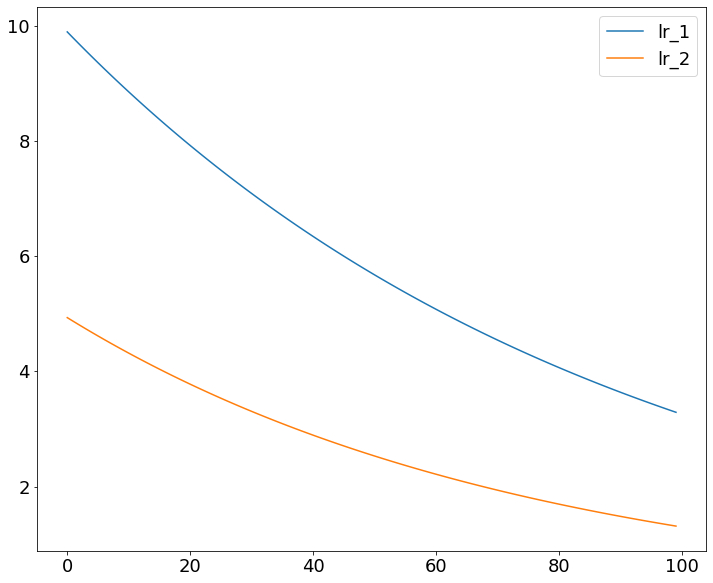

In [14]:
it = np.linspace(1,100,100)

lr_1 = lambda x,maxiter : 10*np.exp(-x/(0.9*maxiter))


lr_2 = lambda x,maxiter : 5*np.exp(-x/(0.75*maxiter))


plt.plot(lr_1(it,100),label='lr_1')

plt.plot(lr_2(it,100),label='lr_2')
plt.legend()


In [15]:

def init_allocation(budget_pos,budget_neg):
    pos_share_tight = np.random.uniform(0,1)
    neg_share_tight=np.random.uniform(0,1)

    a_pos = np.random.dirichlet(np.ones(50))*pos_share_tight*budget_pos 
    b_pos =np.random.dirichlet(np.ones(50))*(1.0-pos_share_tight)*budget_pos 

    init_pos = np.concatenate([a_pos,b_pos])

    a_neg = np.random.dirichlet(np.ones(50))*neg_share_tight*budget_neg
    b_neg =np.random.dirichlet(np.ones(50))*(1.0-neg_share_tight)*budget_neg 

    init_neg =  np.concatenate([a_neg,b_neg])

    init_alloc = np.column_stack([init_pos,init_neg]).T
    return init_alloc



In [ ]:
b = np.zeros(len(G.nodes.keys()))
budget_pos=40.0
budget_neg=20.0


params = {'optimiser_type':'sgd','lr_1':lr_1,'lr_2':lr_2,'beta1':0.8,'beta2':0.999,'eps':0.1}
system = sg.mf_ising_system(G,b,iim_iter=5000,fixed_point_iter=int(5*1e5),iim_tol_fac=1e-1,**params)


beta=0.2

iters=5
pos_degrees=[]
neg_degrees=[]

for i in range(iters):
    control_pos,control_neg,mag=system.MF_IIM(budget_pos,budget_neg,beta)
    controls_pos = system.control_field_history_pos
    controls_neg = system.control_field_history_neg
    print('gradient_pos',sum(system.gradient_history_pos[-1]))
    print('2nd gradient pos',sum(system.grad2pos[-1]))
    temp_pos=[]
    temp_neg=[]
    for idx in range(controls_pos.shape[0]):
        pos_degree = hf.average_degree(system,controls_pos[idx],budget_pos)
        neg_degree = hf.average_degree(system,controls_neg[idx],budget_neg)
        temp_pos.append(pos_degree)
        temp_neg.append(neg_degree)
    
    pos_degrees.append(temp_pos)
    neg_degrees.append(temp_neg)




 48%|███████████████████████████████████▍                                      | 2391/5000 [1:01:17<4:56:58,  6.83s/it]

In [17]:
system.grad2pos[-1]

array([-0.05870063, -0.0924272 , -0.05870063, -0.00330153, -0.00196844,
       -0.0071237 , -0.19269174, -0.13786086, -0.11548111, -0.05849083,
       -0.09538325, -0.26691955, -0.08292234, -0.05587799, -0.0244159 ,
       -0.02308393, -0.02308393, -0.21282957, -0.59775182, -0.59775182,
       -0.7336159 , -0.05723947, -0.0158338 , -0.05093516, -0.05093516,
       -0.21282957, -0.21282957, -0.21282957, -0.02308393, -0.02308393,
       -0.03271785, -0.08115936, -0.05418381, -0.05418381, -0.05436066,
       -0.05436066, -0.42691805, -0.02804483, -0.05077955, -0.04787444,
       -0.23768076, -0.2433174 , -0.23768076, -0.19208165, -0.12119931,
       -0.04989633, -0.15932874, -0.10360714, -0.10360714, -0.07349166,
       -0.15308896, -1.01097327, -0.58339007, -1.69662531, -0.6199842 ,
       -0.37174278, -0.5110555 , -0.5110555 , -0.37879117, -1.09564503,
       -0.78350905, -0.78350905, -1.85040103, -0.75649988, -0.39502302,
       -0.70599705, -0.70599705, -0.35816917, -0.42098512, -0.24

Text(0.5, 1.0, 'Convergence paths for $Budget_{pos}$=40.0 $Budget_{neg}$=20.0')

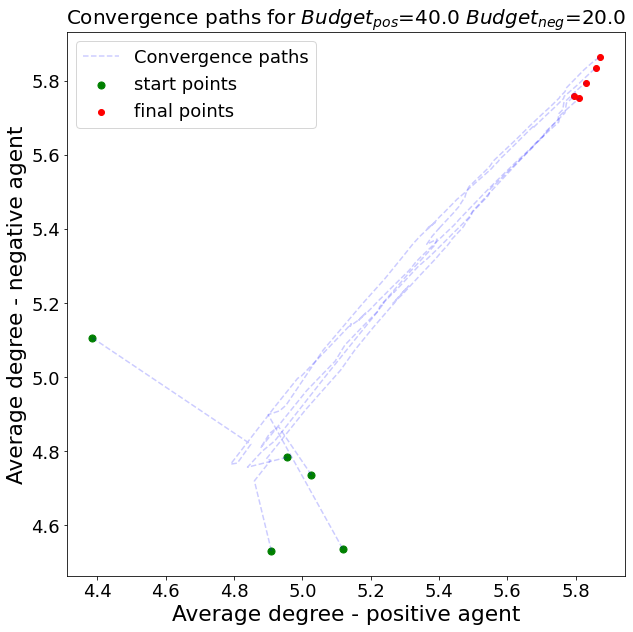

In [18]:
import matplotlib

n=1

matplotlib.rcParams.update({'font.size': 18,'figure.figsize':(12,10),'axes.labelsize': 'large',
                           'axes.titlesize':20})

fig,ax=plt.subplots(figsize=(10,10))

for idx,run in enumerate(pos_degrees):
    
    ax.plot(run[::n],neg_degrees[idx][::n],label='Convergence paths',c='blue',linestyle='dashed',alpha=0.2)
    ax.set_xlabel('Average degree - positive agent')
    ax.set_ylabel('Average degree - negative agent')
    ax.scatter(run[0],neg_degrees[idx][0],c='green',label='start points',s=50)
    ax.scatter(run[-1],neg_degrees[idx][-1],c='red',label='final points')

    hand, labl = ax.get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
        if l not in lablout:
            lablout.append(l)
            handout.append(h)
    ax.legend(handout, lablout,loc='best')
    
        
pos_string = '$Budget_{pos}$'
neg_string = '$Budget_{neg}$'
ax.set_title(r'Convergence paths for {}={} {}={}'.format(pos_string,budget_pos,neg_string,budget_neg))

In [ ]:
beta_min = 0.25*beta_crit 
beta_max = 5*beta_crit 
# needs a wide range of beta to visibly include constant average degree intervals

beta_list = np.logspace(np.log10(beta_min),np.log10(beta_max),num=50,endpoint=True,base=10)
y = np.zeros(len(beta_list))

normal_params = {'graph':G,'background_field':h,
                         'iim_iter':10000,'iim_tol_fac':1e-4,'fixed_point_iter':10000,
                         'step_size':9.0}

system = mf_ising_system(**normal_params) 
# EUREKA - STEP SIZE SEEMS TO BE THE SOLUTION - optimal seems to be 5.0
control_history=[]
for i,beta in enumerate(beta_list):
    control,_=system.MF_IIM(budget,beta)
    control_history.append(control)
    if i%10==0:
        print(i,beta)

print('FINISHED')    

In [ ]:
invalid = {"graph", "background_field"}
def without_keys(d, keys):
    return {x: d[x] for x in d if x not in keys}

def params_name(params,invalid=invalid):
    params_string = [str(key)+str(entry) for key,entry in without_keys(params,invalid).items()]
    string='RealNet_Average_'+'_'.join(params_string)
    return string

params_name(normal_params)

In [ ]:
import matplotlib

matplotlib.rcParams.update({'font.size': 14,'figure.figsize':(7,5),'axes.labelsize': 'large',
                           'axes.titlesize':18})


avs_degrees=np.zeros(len(control_history))
for it,control in enumerate(control_history):
    av_degree = average_degree(G,control,budget)
    avs_degrees[it]=av_degree

fig,ax = plt.subplots()

ax.plot(beta_list,avs_degrees)
ax.set_xscale(value='log')

ax.set_xticks([0.03,0.05,0.1,0.25,0.5])

ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_ylabel('Average degree')
ax.vlines(beta_crit,ymin=min(avs_degrees),ymax=max(avs_degrees),linestyles='dashed',color='red',label='beta')
ax.set_xlabel(r'Interaction Strenght ($\beta$)')
ax.set_title('Distribution of influence \n'+ r'as a function of $\beta$')

#string_name='RealNet_Average'+{}
path = 'C:/Users/zuzan/OneDrive/Dokumenty/Master-Papers/Masters_figures/'


#plt.savefig(path+params_name(normal_params)+'.png'.format(*[normal_params[x] for x in ['step_size','fixed_point_iter','iim_iter']]))
plt.show()
